### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2022
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Análisis y Curación de Datos

Integrantes:
* Fernando Agustin Cardellino
* Adrian Zelaya

### Objetivos:

Normalizar el corpus generado en el práctico anterior, teniendo en cuenta los siguientes aspectos:

* tokenización, 
* pasar a minúsculas, 
* separar puntuación, 
* stemming y lematización, 
* eliminar stopwords (o no), 
* eliminar las palabras con frecuencia menor a n. 

Analizar las palabras más frecuentes de todo el corpus, por fuero y de 5 documentos. Compararlo con el resultado obtenido en el ejercicio anterior. Se observa algún cambio significativo?

Hacer una explicación con ejemplos tomando algunas palabras al azar entre lo que es stemming y lemmatizing para entender que nos da cada uno de estos procesos y cual es conveniente utilizar en cada caso.

Opcional:

* Investigar que es Segmentación y compararlo con Tokenización. Ejemplificar con un documento.
* Investigar NER (Named Entity Recognition - Reconocimiento de Entitades Nombradas). Buscar las Entidadas Nombradas mas frecuentes en todo el corpus y por fuero. 


Fecha de Entrega: 17 de junio de 2022

In [39]:
# Importamos las librerías necesarias

import numpy as np
import pandas as pd
import os
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import porter, snowball
#import nltk
#nltk.download('stopwords')  # Descomentar para bajar las stopwords

In [57]:
# Cargamos modelo de spacy y stopwords de NLTK
nlp = spacy.load("es_core_news_sm")

CURR_DIR = os.getcwd()  # Gets current directory
STOPWORDS_ES = stopwords.words('spanish')
BREAKPOINT=5  # None para analizar todos los documentos, sino un número para analizar hasta n documentos
MAX_WORDS=1000

### Funciones que vamos a utilizar en el Práctico

##### Funciones auxiliares

In [3]:
def getListOfFiles(dirName, return_dir=False):
    # create a list of file and sub directories
    # names in the given directory
    files = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for file in files:
        # Create full path
        fullPath = dirName + "\\" + file
        # If entry is a directory then get the list of files in this directory
        if os.path.isdir(fullPath):
            if return_dir:
                allFiles.append(fullPath.split("\\")[-1])
            else:
                allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)

    return allFiles


def save_to_pickle(obj, filename):
    """
    TODO: [E111] Pickling a token is not supported, because tokens are only views of the parent Doc and can't exist on
    their own. A pickled token would always have to include its Doc and Vocab, which has practically no advantage over
    pickling the parent Doc directly. So instead of pickling the token, pickle the Doc it belongs to.
    :param obj:
    :param filename:
    :return:
    """

    file_path = f"{CURR_DIR}\\{filename}"
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'rb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def series_to_dataframe(series, column_names=None):
    col_names = [series.name, 'values'] if column_names is None else column_names
    return pd.DataFrame([series.index, series.values], columns=col_names)


##### Funciones específicas del análisis

In [68]:
def get_palabras(files_path, fuero_name=None, breakpoint=None):
    """
    Función que arma el corpus de palabras y las tokeniza, utilizando SpaCy.
    Si Breakpoint != None, dar el número de docs con el que se interrumpe la función
    """
    corpus = {}

    palabras = []

    i = 0
    for filename in getListOfFiles(files_path):
        file_name = filename.split("\\")[-1]
        fuero = fuero_name if fuero_name is not None else filename.split("\\")[-2]
        if fuero not in corpus.keys():
            corpus[fuero] = {}

        with open(filename, encoding='utf-8') as file:
            file_text = file.read()
            # Tokenizamos el corpus
            nlp_doc = nlp(file_text)
            corpus[fuero][file_name] = nlp_doc
            for token in nlp_doc:
                 # si es sólo alfabético y si no es stopword
                if token.is_alpha and not token.is_stop:
                    palabras.append(token.lemma_.lower()) # lematizamos y pasamos a minúscula
                    
        # remover esta sección (testing)
        if breakpoint:
            i += 1
            if i > breakpoint:
                break
    return palabras, corpus 

def get_tokens(files_path, fuero_name=None, breakpoint=None):
    """
    Función que arma el corpus de palabras y las tokeniza, utilizando SpaCy.
    Si Breakpoint != None, dar el número de docs con el que se interrumpe la función
    """
    corpus = {}

    palabras = []

    i = 0
    for filename in getListOfFiles(files_path):
        file_name = filename.split("\\")[-1]
        fuero = fuero_name if fuero_name is not None else filename.split("\\")[-2]
        if fuero not in corpus.keys():
            corpus[fuero] = {}

        with open(filename, encoding='utf-8') as file:
            file_text = file.read()
            # Tokenizamos el corpus
            nlp_doc = nlp(file_text)
            corpus[fuero][file_name] = nlp_doc
            for token in nlp_doc:
                 # si es sólo alfabético y si no es stopword
                if token.is_alpha and not token.is_stop:
                    palabras.append(token) # lematizamos y pasamos a minúscula
                    
        # remover esta sección (testing)
        if breakpoint:
            i += 1
            if i > breakpoint:
                break
    return palabras, corpus 


def get_lemmas_stem_from_tokens(tokens, stemmer, language='spanish'):
    aux_dict = {
        'word': [token.lower_ for token in tokens],
        'lemma': [token.lemma_.lower() for token in tokens],
        'stem': [stemmer.stem(token.lower_) for token in tokens]
    }
    return pd.DataFrame(aux_dict)
    

def get_conteo_palabras(palabras):
    """Función que genera un pandas DataFrame con la frecuencia de las palabras
    """
    palabras_df = pd.DataFrame([{'palabra': str(x).lower()} for x in palabras])
    # print(corpus_df.head())

    return palabras_df.groupby(['palabra'])['palabra'].count().sort_values(ascending=False)

    
def comparar_frecuencias_palabras(dataframe, max_palabras=50 ,description=None):
    """Función que compara entre las palabras más y menos frecuentes 
    """
    if description:
        print(description)
    print(
        f"\nLas {max_palabras} palabras más frecuentes son:\n{dataframe.head(max_palabras)}"
    )# La mayoría son todas stopwords, a partir de la 20ma empiezan a haber palabras propias del ámbito jurídico
    
    print(f"\nLas {max_palabras} palabras menos frecuentes son:\n{dataframe.tail(max_palabras)}"
    )  # palabras normales pero donde la mayoría comparte una base en común (e.g. ordenadas, ordenado, ordenando) >> con lematización, se podría disminuir esto
    
    return dataframe.head(max_palabras).index.values


def plot_histogram(dataframe, threshold=1, y_low=None, description=None):

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    plt.figure(figsize=(20, 8), dpi=80)
    
    limit = threshold if threshold else len(dataframe)
    
    x=dataframe[:limit].index 
    y=dataframe[:limit].values
    
    y_cutoff = dataframe[:threshold].quantile(0.8) if y_low is None else y_low
    
    my_color = np.where(y>=y_cutoff, 'orange', 'skyblue')
    
    # The vertical plot is made using the vline function
    plt.vlines(x=x, ymin=0, ymax=y, color=my_color, alpha=0.4, linewidth=3.5)
    plt.scatter(x, y, color=my_color, s=25, alpha=1)

    # Add title and axis names
    identifier = '' if description is None else f" ({description})"
    
    plt.title(f"Distribución de Frecuencia de Palabras{identifier}", loc='center')
    plt.xlabel('Palabra')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation = 45)
    
    # Formateamos los valores del eje-y
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

    # Show the graph
    plt.show()
    
def show_zipf(dataframe, description=None):
    """Función que grafica la Ley de Zipf (scatterplot con ejes en escala logarítmica)
    """
    sns.set(style="darkgrid")
    
    rank_palabras = [x + 1 for x in range(len(dataframe))]
    
    sns.scatterplot(x=rank_palabras,
                    y=dataframe).set(xscale="log",
                                     yscale="log",
                                     ylabel='log(Frecuencia)',
                                     xlabel='log(Orden)')
    
    identifier = '' if description is None else f" ({description})"
    plt.title(f"Ley de Zipf{identifier}", loc='center')
    
    plt.show()
    

def generar_wordcloud(img_name, stopwords, tokens, output_path, max_words=MAX_WORDS):
    """Función que genera una nube de palabras (wordcloud) sobre una imagen de fondo.    
    """
    
    image_name = f"img/{img_name}.jpg" 

    
    # Generate a word cloud image
    mask = np.array(Image.open(image_name))
    text = ' '.join(tokens)
    wordcloud_law = WordCloud(
        stopwords=stopwords,
        background_color="white", 
        mode="RGBA",
        max_words=max_words,
        mask=mask).generate(text)
    
    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[7, 7])
    plt.imshow(wordcloud_law.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    
    # store to file
    plt.savefig(output_path, format="png")
    
    plt.show()

### Normalización del corpus
Normalizar el corpus generado en el práctico anterior, teniendo en cuenta los siguientes aspectos:
- tokenización,
- pasar a minúsculas,
- separar puntuación,
- stemming y lematización,
- eliminar stopwords (o no),
- eliminar las palabras con frecuencia menor a n.

Analizar las palabras más frecuentes de todo el corpus, por fuero y de 5 documentos. Compararlo con el resultado obtenido en el ejercicio anterior. Se observa algún cambio significativo?

Hacer una explicación con ejemplos tomando algunas palabras al azar entre lo que es stemming y lemmatizing para entender que nos da cada uno de estos procesos y cual es conveniente utilizar en cada caso.

Opcional:

Investigar que es Segmentación y compararlo con Tokenización. Ejemplificar con un documento.
Investigar NER (Named Entity Recognition - Reconocimiento de Entitades Nombradas). Buscar las Entidadas Nombradas mas frecuentes en todo el corpus y por fuero.

In [5]:
# Ubicación de los documentos
filesDir = f"{CURR_DIR}\Documentos"

# Obtenemos lista de los fueros
fueros = getListOfFiles(filesDir, return_dir=True)

In [35]:
# Generamos el corpus de palabras, y el diccionario con el mapeo de los fueros con sus respectivos documentos
palabras, corpus_dic = get_palabras(filesDir, breakpoint=BREAKPOINT)

frecuencia_palabras_df = get_conteo_palabras(palabras)

#print(frecuencia_palabras_df)
print(palabras)

['córdoba', 'veinticuatro', 'septiembre', 'mil', 'dieciocho', 'vistos', 'auto', 'caratulado', 'control', 'legalidad', 'ley', 'art', 'expte', 'n', 'venido', 'juzgado', 'niñez', 'adolescencia', 'violencia', 'familiar', 'nominación', 'secretaría', 'ex', 'men', 'sec', 'cargo', 'carlos', 'maría', 'lópez', 'peña', 'resultar', 'i', 'fs', 'comparecer', 'señora', 'asesora', 'letrada', 'civil', 'quinto', 'turno', 'interponer', 'recurso', 'reposición', 'apelación', 'subsidio', 'proveído', 'fecha', 'fs', 'disponer', 'tener', 'consideración', 'precepto', 'rector', 'actuación', 'interés', 'superior', 'niño', 'constancia', 'obrant', 'fs', 'vta', 'surgir', 'señor', 'vivir', 'domicilio', 'sito', 'calle', 'b', 'barrio', 'quebrado', 'rosas', 'conteste', 'domicilio', 'fijado', 'registro', 'electoral', 'obra', 'constancia', 'fs', 'tornar', 'absolutamente', 'abstracto', 'esgrimido', 'señora', 'asesora', 'letrada', 'civil', 'comercial', 'quinto', 'turno', 'motivo', 'imperante', 'fin', 'asumir', 'patrocinio',

In [69]:
# Stemming vs Lematization
# Snowball stemmer is a slightly improved version of the Porter stemmer and is usually preferred over the latter. (https://stackabuse.com/python-for-nlp-tokenization-stemming-and-lemmatization-with-spacy-library/)
# Also Snowball supports Spanish
stemmer = snowball.SnowballStemmer(language='spanish')

tokens, _ =  get_tokens(filesDir, breakpoint=BREAKPOINT)

palabras_df = get_lemmas_stem_from_tokens(tokens, stemmer=stemmer)

palabras_df


,word,lemma,stem
0,córdoba,córdoba,cordob
1,veinticuatro,veinticuatro,veinticuatr
2,septiembre,septiembre,septiembr
3,mil,mil,mil
4,dieciocho,dieciocho,diecioch
...,...,...,...
12309,cód,cód,cod
12310,arancelario,arancelario,arancelari
12311,protocolícese,protocolícese,protocolices
12312,hágase,hágase,hag


C:\Users\azelaya004\AppData\Local\Temp\ipykernel_9824\2624117922.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


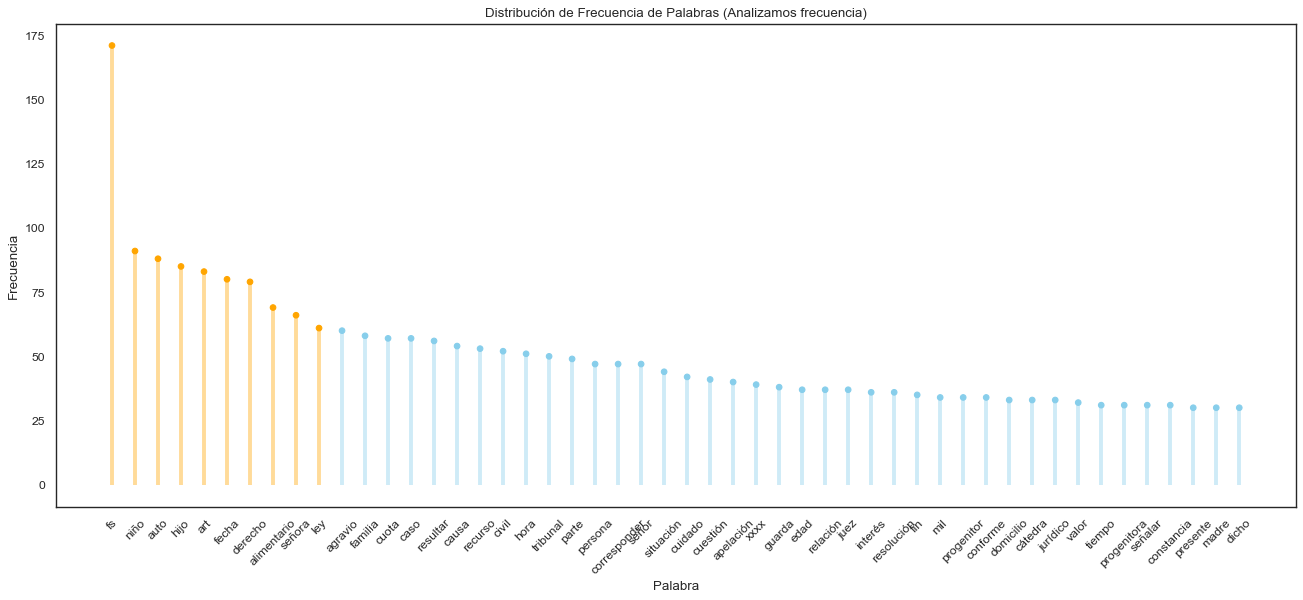

In [55]:
identifier = 'Analizamos frecuencia'

#show_histogram(frecuencia_palabras_df, threshold=1)
plot_histogram(
    frecuencia_palabras_df,
    threshold=50,  # Nos quedamos con las 50 palabras más frecuentes
    y_low=None,
    description=identifier)

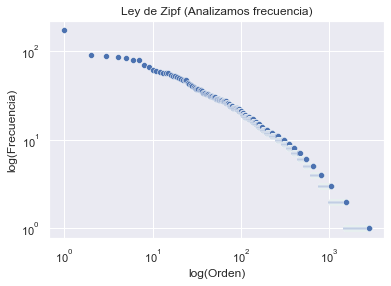

In [53]:
show_zipf(frecuencia_palabras_df, description=identifier)

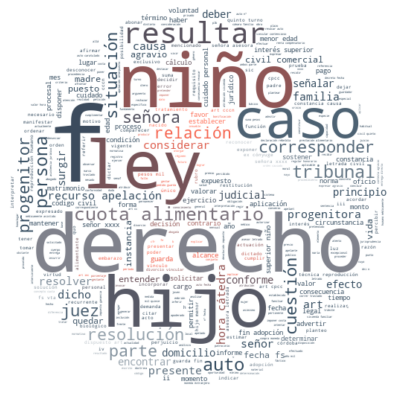

In [62]:
img_name = "legal-icon-png"
output_name = f"img/{img_name}_wordcloud_practico_2_ALL.png"

generar_wordcloud(img_name, STOPWORDS_ES, palabras, output_name)

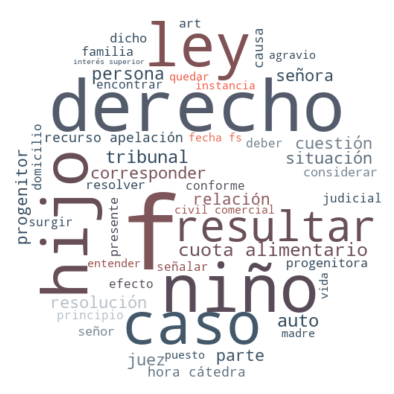

In [64]:
# n más frecuente
n = 50
output_name = f"img/{img_name}_wordcloud_practico_2_n{n}.png"

generar_wordcloud(img_name, STOPWORDS_ES, palabras, output_name, max_words=n)